## Dev

In [56]:
%pip install -qU langchain-community langgraph langgraph-checkpoint-sqlite langchain-openai langchain-groq langchain_mistralai

Note: you may need to restart the kernel to use updated packages.


### LangGraph

In [2]:
from typing import Annotated, Literal, Sequence, List, Any, Dict
from typing_extensions import TypedDict
from pprint import pprint

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.callbacks.base import BaseCallbackHandler

from pydantic import BaseModel, Field

import sys
sys.path.insert(1, '../DefAgent')

import src.prompts as prompts
import src.utils as utils
import src.tools as tools
import src.models as models
import src.retriever as retriever

In [36]:
class CustomHandler(BaseCallbackHandler):
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        formatted_prompts = "\n".join(prompts)
        print(f"-> PROMPT:\n{formatted_prompts}\n")


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    input_query: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


class DefAgent:
    def __init__(self, model):
        self.model = model
        self.vectorstore = retriever.setup_vectorstore()
        self.retriever_tool = tools.create_vector_search_tool(self.vectorstore)
        self.tools = [self.retriever_tool]
        self.workflow = self.setup_workflow()

    def agent(self, state):
        """
        Invokes the agent model to generate a response based on the current state. Given
        the question, it will decide to retrieve using the retriever tool, or simply end.

        Args:
            state (messages): The current state

        Returns:
            dict: The updated state with the agent response appended to messages
        """
        print("---QURY AGENT---")
        model = self.model.bind_tools(self.tools)
        input_query = state["input_query"]
        messages = state["messages"]
        response = model.invoke(messages, config={"callbacks": [CustomHandler()]})
        return {"messages": [response], "input_query": input_query}
    

    def filter_definitions(self, state) -> Literal["generate"]:
        """
        Filters the retrieved definitions based on their relevance to the question.

        Args:
            state (messages): The current state

        Returns:
            List[dict]: A list of dictionaries containing the relevant definitions and their metadata.
        """

        print("---FILTER DEFINITIONS---")

        class DefinitionMetadata(BaseModel):
            id: int = Field(description="the unique identifier of the definition")
            dataset: str = Field(description="the dataset the definition is from")
            document_id: str = Field(description="the document id the definition is from")
            references: List[str] = Field(description="the references mentioned the definition.")

        class Definition(BaseModel):
            metadata: DefinitionMetadata
            definition_text: str = Field(description="the full text of the definition")  # Changed from 'definition'

        class DefinitionsList(BaseModel):
            relevant_definitions: List[Definition] = Field(description="a list of relevant definitions")

        parser = PydanticOutputParser(pydantic_object=DefinitionsList)

        prompt = PromptTemplate(
            template="""
            You are a legal expert assessing the relevance of legal definitions to a user question. \n 
            Your job is to filter the list of definitions provided to you keeping only the relevant ones. \n
            If the definition contains keyword(s) or semantic meaning related to the user's question, keep it.\n
            Output only the relevant definitions using the formatting instructions provided. \n
            Here are the formatting instructions: {format_instructions} \n
            Here are the retrieved definitions, one for each line: \n {context} \n
            Here is the user question: {question} \n
            """,
            input_variables=["context", "question"],
            partial_variables={"format_instructions": parser.get_format_instructions()}
        )

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        chain = prompt | self.model

        messages = state["messages"]
        last_message = messages[-1]

        question = state["input_query"]
        docs = last_message.content

        response = chain.invoke({"question": question, "context": docs}, config={"callbacks": [CustomHandler()]})

        return {"messages": [response]}


    def generate(self, state):
        """
        Generate definition

        Args:
            state (messages): The current state

        Returns:
            str: A legal definition
        """
        print("---GENERATE---")
        messages = state["messages"]
        question = state["input_query"]
        last_message = messages[-1]

        docs = last_message.content

        prompt = PromptTemplate(
            template="""
            You are a legal assistant for the task of generating legal definitions. \n
            Use the following retrieved definitions as context to answer the question. \n
            If you don't know the answer, just say that you don't know. \n
            Keep the answer concise and straight to the point, giving only the definition.
            Question: {question} \n
            Context: {context} \n
            Answer:
            """,
            input_variables=["context", "question"]
        )

        llm = self.model

        def format_docs(docs):
            return "\n\n".join(doc.page_content for doc in docs)

        rag_chain = prompt | llm | StrOutputParser()

        response = rag_chain.invoke({"context": docs, "question": question}, config={"callbacks": [CustomHandler()]})
        return {"messages": [response]}
    

    def eurlex_agent(self, state):
        raise NotImplementedError

    def normattiva_agent(self, state):
        raise NotImplementedError

    def pdl_agent(self, state):
        raise NotImplementedError

    def setup_workflow(self):
        workflow = StateGraph(AgentState)

        workflow.add_node("agent", self.agent)  # agent
        workflow.add_node("retrieve", ToolNode([self.retriever_tool]))  # retrieval
        workflow.add_node("filter", self.filter_definitions)  # retrieval
        workflow.add_node("generate", self.generate)  # Generating a response after we know the documents are relevant
        #workflow.add_node("RefResolver", self.resolve_references)
        #workflow.add_node("EurLex agent", self.eurlex_agent)
        #workflow.add_node("Normattiva agent", self.normattiva_agent)
        #workflow.add_node("PDL agent", self.pdl_agent)


        workflow.add_edge(START, "agent")

        # Decide whether to retrieve
        workflow.add_conditional_edges(
            "agent",
            # Assess agent decision
            tools_condition,
            {
                # Translate the condition outputs to nodes in our graph
                "tools": "retrieve",
                END: END,
            },
        )

        workflow.add_edge("retrieve", "filter")
        #workflow.add_edge("filter", "RefResolver")
        workflow.add_edge("filter", "generate")
        #workflow.add_edge("generate", "EurLex agent")
        #workflow.add_edge("generate", "Normattiva agent")
        #workflow.add_edge("generate", "PDL agent")
        #workflow.add_edge("EurLex agent", END)
        #workflow.add_edge("Normattiva agent", END)
        #workflow.add_edge("PDL agent", END)
        workflow.add_edge("generate", END)

        self.graph = workflow.compile()

        return workflow
    
    def invoke(self, query):
        inputs = {
            "input_query": query,
            "messages": [
                ("system", ''),
                ("user", query),
            ]
        }

        for output in self.graph.stream(inputs):
            for key, value in output.items():
                print(f"<- OUTPUT from node '{key}':\n")
                print(value['messages'][-1])#, indent=2, width=80, depth=None)
            print("\n---\n")

model = models.groq
defagent = DefAgent(model)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

---

## Use

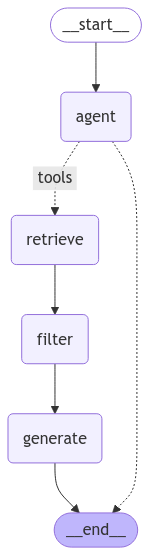

In [37]:
graph = defagent.graph

utils.draw_graph(graph)

In [38]:
defagent.model = models.groq

defagent.invoke('Quale è la definizione di soft drink?')

---QURY AGENT---
-> PROMPT:
System: 
Human: Quale è la definizione di soft drink?

<- OUTPUT from node 'agent':

content='' additional_kwargs={'tool_calls': [{'id': 'call_39xf', 'function': {'arguments': '{"input":"definition of soft drink"}', 'name': 'vector_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 941, 'total_tokens': 1010, 'completion_time': 0.0575, 'prompt_time': 0.042832882, 'queue_time': 0.001519887999999997, 'total_time': 0.100332882}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-222e98f5-7418-4cc2-baa0-c377d512a709-0' tool_calls=[{'name': 'vector_search', 'args': {'input': 'definition of soft drink'}, 'id': 'call_39xf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 941, 'output_tokens': 69, 'total_tokens': 1010}

---

<- OUTPUT from node 'retrieve':

content='[Document(metadata={\'dataset\': \'EurLex\', \'document_id\': \

---